# data 불러오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

In [2]:
# file_path = "/content/현대자동차.csv"
# corps_name = file_path.split('/')[2].split('.')[0] # corps_name = "현대자동차" # 기업명 - 시각화 그래프에 사용

In [3]:
stock = pd.read_csv(file_path, index_col=0)

print(stock.shape)
stock

(1598, 10)


,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
2021-06-30,239500,0,0.00,240000,241000,238500,653096,156348960372,51173530786500,213668187
2021-06-29,239500,-1500,-0.62,240500,242500,239000,627915,150635106000,51173530786500,213668187
2021-06-28,241000,-2000,-0.82,244000,244500,240000,575102,138789048000,51494033067000,213668187
2021-06-25,243000,500,0.21,243500,244000,241000,537893,130455190500,51921369441000,213668187
2021-06-24,242500,0,0.00,243500,249000,241000,1494131,365731706500,51814535347500,213668187
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,178000,8000,4.71,172500,178000,171000,902742,158423821252,39209213262000,220276479
2015-01-07,170000,5500,3.34,163000,171500,163000,511006,86384012000,37447001430000,220276479
2015-01-06,164500,-3500,-2.08,166500,167000,164000,635059,104856982500,36235480795500,220276479
2015-01-05,168000,-1000,-0.59,171000,171000,166000,454073,76211663500,37006448472000,220276479


## 10일 간격의 데이터로 다음 날 주식 종가를 예측하기 위한 학습 데이터 생성

In [4]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
train_feature = None
train_label = None

In [8]:
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 10)

In [9]:
train_feature[0], train_label[0]

(array([[ 240000,  241000,  238500,  653096],
        [ 240500,  242500,  239000,  627915],
        [ 244000,  244500,  240000,  575102],
        [ 243500,  244000,  241000,  537893],
        [ 243500,  249000,  241000, 1494131],
        [ 242000,  243000,  239000,  843399],
        [ 235500,  243000,  235000, 1299242],
        [ 234000,  236000,  232000,  823355],
        [ 237000,  238000,  235000, 1036077],
        [ 239000,  239500,  236000,  724881]]), array([239500]))

# Keras RNN

## 입력변수 & 목표변수

In [10]:
X = train_feature
y = train_label

In [11]:
print(X.shape)
print(y.shape)

(1588, 10, 4)
(1588, 1)


## 데이터 분할

In [12]:
from sklearn.model_selection import train_test_split

# train:test - 8:2 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train:val - 8:2 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Keras 모델 만들기

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [22]:
model = Sequential()
model.add(SimpleRNN(8, activation='relu', input_shape=X_train.shape[1:]))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

history = model.fit(X_train, y_train, epochs=50, verbose=2, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 - 1s - loss: 114138808320.0000 - mse: 114138808320.0000 - val_loss: 57147375616.0000 - val_mse: 57147375616.0000
Epoch 2/50
32/32 - 0s - loss: 81736458240.0000 - mse: 81736458240.0000 - val_loss: 43785494528.0000 - val_mse: 43785494528.0000
Epoch 3/50
32/32 - 0s - loss: 68350713856.0000 - mse: 68350713856.0000 - val_loss: 31275079680.0000 - val_mse: 31275079680.0000
Epoch 4/50
32/32 - 0s - loss: 50357432320.0000 - mse: 50357432320.0000 - val_loss: 25742411776.0000 - val_mse: 25742411776.0000
Epoc

## loss 변화 시각화

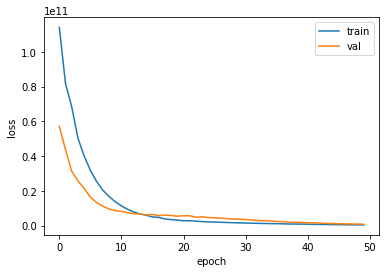

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

## 학습 & 테스트 결과

In [24]:
from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse.round(2)}")
print(f"Test RMSE: {test_rmse.round(2)}")

Train RMSE: 19890.94
Test RMSE: 11383.75


## test 예측 결과 시각화

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_test.ravel(),
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=test_pred.ravel(),
                    line=dict(dash='dash', width=3),
                    name='pred'))

fig.update_layout(
    title=f"{corps_name} 종가 실제값-예측값",
    height=500)
fig.show()